## Module 2 Homework

In this homework, we're going to combine data from various sources to process it in Pandas and generate additional fields.

If not stated otherwise, please use the [LINK](https://github.com/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/02-dataframe-analysis/%5B2025%5D_Module_02_Colab_Working_with_the_data.ipynb) covered at the livestream to re-use the code snippets.

In [2]:
# IMPORTS
import pandas as pd
import requests
from io import StringIO
import time
import numpy as np

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

import matplotlib.pyplot as plt
import datetime

---
### Question 1: [IPO] Withdrawn IPOs by Company Type

**What is the total withdrawn IPO value (in $ millions) for the company class with the highest total withdrawal value?**

From the withdrawn IPO list ([stockanalysis.com/ipos/withdrawn](https://stockanalysis.com/ipos/withdrawn/)), collect and process the data to find out which company type saw the most withdrawn IPO value.

#### Steps:
1. Use `pandas.read_html()` with the URL above to load the IPO withdrawal table into a DataFrame. 
   *It is a similar process to Code Snippet 1 discussed at the livestream.*    You should get **99 entries**. 
2. Create a new column called `Company Class`, categorizing company names based on patterns like:
   - “Acquisition Corp” or “Acquisition Corporation” → `Acq.Corp`
   - “Inc” or “Incorporated” → `Inc`
   - “Group” → `Group`
   - “Holdings” → `Holdings`
   - “Ltd” or “Limited” → `Ltd`
   - Others → `Other`

  * Hint: make your function more robust by converting names to lowercase and splitting into words before matching patterns.

3. Define a new field `Avg. price` by parsing the `Price Range` field (create a function and apply it to the `Price Range` column). Examples:
   - '$8.00-$10.00' → `9.0`  
   - '$5.00' → `5.0`  
   - '-' → `None`
4. Convert `Shares Offered` to numeric, clean missing or invalid values.
5. Create a new column:  
   `Withdrawn Value = Shares Offered * Avg Price` (**71 non-null values**)
6. Group by `Company Class` and calculate total withdrawn value.
7. **Answer**: Which class had the highest **total** value of withdrawals?

**Load table**

In [3]:
def get_withdrawn_ipos() -> pd.DataFrame:
    """
    Fetch IPO data for withdrawn IPOs from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/withdrawn/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

df_withdrawn_ipos = get_withdrawn_ipos()
df_withdrawn_ipos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Symbol          100 non-null    object
 1   Company Name    100 non-null    object
 2   Price Range     100 non-null    object
 3   Shares Offered  100 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB


🚨 100 entries!

In [4]:
pd.set_option('display.max_rows', 50)

**Classify companies – add a Company Class column using patterns**

In [5]:
def classify(name):
    name = name.replace(',', '').replace('.', '')
    n = name.lower().split()
    if "acquisition" in n and ("corp" in n or "corporation" in n):
        return "Acq.Corp"
    if "inc" in n or "incorporated" in n:
        return "Inc"
    if "group" in n:
        return "Group"
    if "holdings" in n:
        return "Holdings"
    if "ltd" in n or "limited" in n:
        return "Ltd"
    return "Other"

df_withdrawn_ipos['Company Class'] = df_withdrawn_ipos['Company Name'].apply(classify)

In [6]:
df_withdrawn_ipos

,Symbol,Company Name,Price Range,Shares Offered,Company Class
0,ODTX,"Odyssey Therapeutics, Inc.",-,-,Inc
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000,Inc
2,AURN,"Aurion Biotech, Inc.",-,-,Inc
3,ROTR,"PHI Group, Inc.",-,-,Inc
4,ONE,One Power Company,-,-,Other
...,...,...,...,...,...
95,FHP,"Freehold Properties, Inc.",-,-,Inc
96,CHO,Chobani Inc.,-,-,Inc
97,IFIT,iFIT Health & Fitness Inc.,$18.00 - $21.00,30769231,Inc
98,GLGX,"Gerson Lehrman Group, Inc.",-,-,Inc


🚨 multiple COMPANY CLASS

<Axes: xlabel='Company Class'>

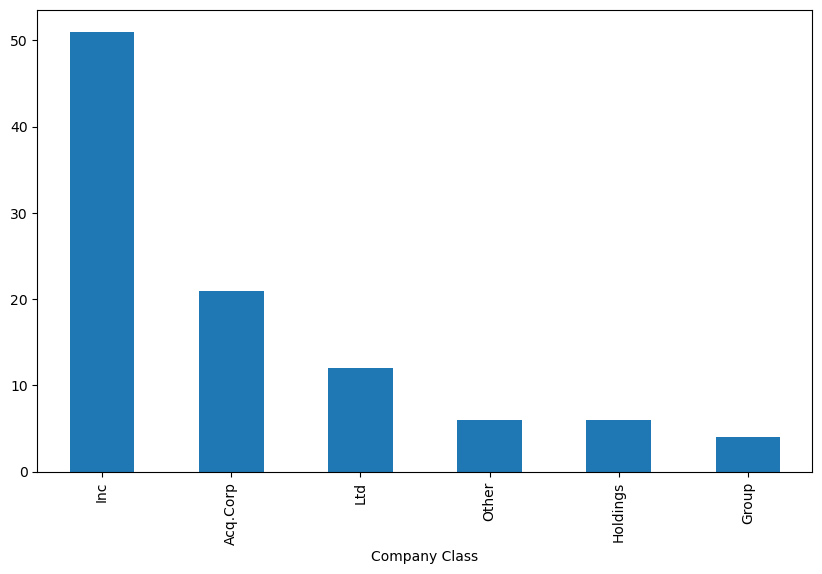

In [7]:
df_withdrawn_ipos['Company Class'].value_counts().plot(kind='bar', figsize=(10, 6))

**Compute average price – parse Price Range**

In [8]:
def avg_price(pr):
    if pd.isna(pr) or pr.strip() == "-":
        return np.nan
    parts = pr.replace('$','').split('-')
    try:
        return float(parts[0]) if len(parts)==1 else (float(parts[0])+float(parts[1]))/2
    except:
        return np.nan
    
df_withdrawn_ipos['Avg Price'] = df_withdrawn_ipos['Price Range'].apply(avg_price)
df_withdrawn_ipos[['Price Range', 'Avg Price']].tail(20)

,Price Range,Avg Price
80,-,NaN
81,$10.00,10.0
82,$10.00,10.0
83,-,NaN
84,$10.00,10.0
85,-,NaN
86,$13.00 - $15.00,14.0
87,$10.00,10.0
88,$10.00,10.0
89,-,NaN


**Clean shares and compute withdrawal value**

In [9]:
df_withdrawn_ipos['Shares Offered'] = pd.to_numeric(df_withdrawn_ipos['Shares Offered'], errors='coerce')
df_withdrawn_ipos['Withdrawn Value'] = df_withdrawn_ipos['Shares Offered'] * df_withdrawn_ipos['Avg Price']

In [10]:
df_withdrawn_ipos['Withdrawn Value'].notnull().sum()

np.int64(71)

In [11]:
total_by_class = df_withdrawn_ipos.groupby('Company Class')['Withdrawn Value'].sum().sort_values(ascending=False)
print(total_by_class)

Company Class
Acq.Corp    4.021000e+09
Inc         2.257164e+09
Other       7.679200e+08
Ltd         3.217346e+08
Holdings    3.030000e+08
Group       3.378750e+07
Name: Withdrawn Value, dtype: float64


---
### Question 2:   [IPO] Median Sharpe Ratio for 2024 IPOs (First 5 Months)


**What is the median Sharpe ratio (as of 6 June 2025) for companies that went public in the first 5 months of 2024?**

The goal is to replicate the large-scale `yfinance` OHLCV data download and perform basic financial calculations on IPO stocks.

#### Steps:

1. Using the same approach as in Question 1, download the IPOs in 2024 from:  
   [https://stockanalysis.com/ipos/2024/](https://stockanalysis.com/ipos/2024/)  
   Filter to keep only those IPOs **before 1 June 2024** (first 5 months of 2024).  
   ➤ You should have **75 tickers**.

In [79]:
def get_ipos_by_year(year: int) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [80]:
ipos_2024 = get_ipos_by_year(2024)
ipos_2024.columns = ipos_2024.columns.str.strip().str.replace(' ', '_').str.lower()
ipos_2024['ipo_date'] = pd.to_datetime(ipos_2024['ipo_date'])
ipos_2024_may = ipos_2024[ipos_2024.ipo_date < datetime.datetime(2024, 6, 1)].reset_index(drop=True)

In [88]:
IPO_2024_TICKERS = ['BOW','HDL','RFAI','JDZG','RAY','BTOC','ZK','GPAT','PAL','SVCO','NNE','CCIX','VIK','ZONE','LOAR','MRX','RBRK','NCI','MFI','YYGH','TRSG','CDTG','CTRI','IBTA','MTEN','TWG','ULS','PACS','MNDR','CTNM','MAMO','ZBAO','BOLD','MMA','UBXG','IBAC','AUNA','BKHA','LOBO','RDDT','ALAB','INTJ','RYDE','LGCL','SMXT','VHAI','DYCQ','CHRO','UMAC','HLXB','MGX','TBBB','TELO','KYTX','PMNT','AHR','LEGT','ANRO','GUTS','AS','FBLG','AVBP','BTSG','HAO','CGON','YIBO','JL','SUGP','JVSA','KSPI','CCTG','PSBD','SYNX','SDHC','ROMA'
                    #'NAKA', 'SUPX' -- remove tickers w/ no ipo_price
                    ]

In [93]:
len(IPO_2024_TICKERS)

75

2.  Use **Code Snippet 7** to download daily stock data for those tickers (via `yfinance`).  
   Make sure you understand how `growth_1d` ... `growth_365d`, and volatility columns are defined.  
   Define a new column `growth_252d` representing growth after **252 trading days** (~1 year), in addition to any other growth periods you already track.

In [96]:
stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(IPO_2024_TICKERS):
  print(i,ticker)

  # Work with stock prices
  ticker_obj = yf.Ticker(ticker)

  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Day'] = historyPrices.index.day
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,252,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-5) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 BOW
1 HDL
2 RFAI
3 JDZG
4 RAY
5 BTOC
6 ZK
7 GPAT
8 PAL
9 SVCO
10 NNE
11 CCIX
12 VIK
13 ZONE
14 LOAR
15 MRX
16 RBRK
17 NCI
18 MFI
19 YYGH
20 TRSG
21 CDTG
22 CTRI
23 IBTA
24 MTEN
25 TWG
26 ULS
27 PACS
28 MNDR
29 CTNM
30 MAMO
31 ZBAO
32 BOLD
33 MMA
34 UBXG
35 IBAC
36 AUNA
37 BKHA
38 LOBO
39 RDDT
40 ALAB
41 INTJ
42 RYDE
43 LGCL
44 SMXT
45 VHAI
46 DYCQ
47 CHRO
48 UMAC
49 HLXB
50 MGX
51 TBBB
52 TELO
53 KYTX
54 PMNT
55 AHR
56 LEGT
57 ANRO
58 GUTS
59 AS
60 FBLG
61 AVBP
62 BTSG
63 HAO
64 CGON
65 YIBO
66 JL
67 SUGP
68 JVSA
69 KSPI
70 CCTG
71 PSBD
72 SYNX
73 SDHC
74 ROMA


3. Calculate the Sharpe ratio assuming a risk-free rate of **4.5%**:

   ```python
   stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']
   ```

In [97]:
stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']

4. Filter the DataFrame to keep data only for the trading day:  
   **‘2025-06-06’**

   Compute descriptive statistics (e.g., `.describe()`) for these columns:  
   - `growth_252d`  
   - `Sharpe`

   You should observe:  
   - `growth_252d` is defined for **71 out of 75 stocks** (some IPOs are too recent or data starts later).  
   - Median `growth_252d` is approximately **0.75** (indicating a 25% decline), while mean is about **1.15**, showing a bias towards high-growth companies pushing the average up.


In [100]:
stocks_df_20250606 = stocks_df[
  (stocks_df.Year == 2025) 
& (stocks_df.Month == 6) 
& (stocks_df.Day == 6)
]

In [101]:
stocks_df_20250606[['growth_252d', 'Sharpe']].describe()

,growth_252d,Sharpe
count,71.000000,71.000000
mean,1.152897,0.301597
std,1.406017,0.529685
min,0.024970,-0.079677
25%,0.293422,0.041215
50%,0.758065,0.083768
75%,1.362736,0.335681
max,8.097413,2.835668


5. **Answer:**  
   - What is the **median Sharpe ratio** for these 71 stocks?  
   - Note: Positive `Sharpe` means growth exceeding the risk-free rate of 4.5%.  
   - [Additional] Do you observe the **same top 10 companies** when sorting by `growth_252d` versus sorting by `Sharpe`?


In [102]:
median_sharpe = stocks_df_20250606['Sharpe'].median()
median_sharpe

0.0837682300329437

In [105]:
stocks_df_20250606.sort_values(by='Sharpe', ascending=False).head(10)[['Ticker', 'Sharpe', 'growth_252d']]

,Ticker,Sharpe,growth_252d
10745,BKHA,2.835668,1.045881
20887,JVSA,2.041531,1.071076
16765,LEGT,1.940267,1.049407
10164,IBAC,1.637119,1.044611
4871,NCI,1.181375,0.572687
14436,HLXB,1.123493,1.061404
8068,MNDR,0.974234,1.030769
13433,DYCQ,0.969321,1.059863
11982,INTJ,0.744512,0.661386
20221,JL,0.566222,8.097413


In [106]:
stocks_df_20250606.sort_values(by='growth_252d', ascending=False).head(10)[['Ticker', 'Sharpe', 'growth_252d']]

,Ticker,Sharpe,growth_252d
20221,JL,0.566222,8.097413
23015,ROMA,0.486840,6.156406
14099,UMAC,0.421306,4.966533
2918,NNE,0.080707,4.655224
4584,RBRK,0.019051,3.184065
16461,AHR,0.112576,2.483097
17792,AS,0.028026,2.478203
4299,MRX,0.076540,2.300384
11362,RDDT,0.019543,2.225505
6892,MTEN,0.053200,2.210432


---
### Question 3: [IPO] ‘Fixed Months Holding Strategy’

**What is the optimal number of months (1 to 12) to hold a newly IPO'd stock in order to maximize average growth?**  
(*Assume you buy at the close of the first trading day and sell after a fixed number of trading days.*)


---

#### Goal:
Investigate whether holding an IPO stock for a fixed number of months after its first trading day produces better returns, using future growth columns.

---


#### Steps:

1. **Start from the existing DataFrame** from Question 2 (75 tickers from IPOs in the first 5 months of 2024).  

   Add **12 new columns**:  
   `future_growth_1m`, `future_growth_2m`, ..., `future_growth_12m`  
   *(Assume 1 month = 21 trading days, so growth is calculated over 21, 42, ..., 252 trading days)*  
   This logic is similar to `historyPrices['growth_future_30d']` from **Code Snippet 7**, but extended to longer timeframes.


In [110]:
stocks_df.Ticker.nunique()

75

In [112]:
for m in range(1, 13):
    days = 21 * m
    stocks_df[f'future_growth_{m}m'] = (
        stocks_df.groupby('Ticker')['Close']
        .transform(lambda x: x.shift(-days) / x)
    )


In [116]:
stocks_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
0,23.000000,24.270000,22.139999,23.799999,3335800,0.0,0.0,BOW,2024,5,...,1.301681,1.167647,1.239076,1.461765,1.443698,1.357983,1.389076,1.722689,1.698319,1.533613
1,24.260000,26.150000,23.980000,25.700001,990500,0.0,0.0,BOW,2024,5,...,1.196498,1.090661,1.148249,1.392996,1.354086,1.280934,1.276654,1.640078,1.589883,1.445914
2,25.850000,26.879999,25.075001,26.480000,555100,0.0,0.0,BOW,2024,5,...,1.155589,1.048338,1.111027,1.361783,1.327039,1.233761,1.270015,1.535121,1.517749,1.408610
3,26.440001,26.490000,25.500999,26.290001,302700,0.0,0.0,BOW,2024,5,...,1.149106,1.053252,1.139977,1.378851,1.311525,1.248764,1.315709,1.559528,1.521491,1.430582
4,27.209999,27.209999,25.500000,26.139999,200900,0.0,0.0,BOW,2024,5,...,1.198164,1.071538,1.149579,1.383321,1.321729,1.236802,1.303367,1.595639,1.584545,1.432670


2. **Determine the first trading day** (`min_date`) for each ticker.  
   This is the earliest date in the data for each stock.

In [120]:
# Step 2: Determine the first trading date per ticker
min_dates = (
    stocks_df.groupby('Ticker')['Date']
    .min()
    .reset_index()
    .rename(columns={'Date': 'min_date'})
)

In [122]:
pd.set_option('display.max_rows', 50)

3. **Join the data**:  
   Perform an **inner join** between the `min_date` DataFrame and the future growth data on both `ticker` and `date`.  
   ➤ You should end up with **75 records** (one per IPO) with all 12 `future_growth_...` fields populated.

In [124]:
first_day_df = pd.merge(
    stocks_df,
    min_dates,
    how='inner',
    left_on=['Ticker', 'Date'],
    right_on=['Ticker', 'min_date']
)


In [132]:
first_day_df[first_day_df.future_growth_10m.isnull()
| first_day_df.future_growth_11m.isnull()
| first_day_df.future_growth_12m.isnull()][['Ticker', 'Date', 'future_growth_10m', 'future_growth_11m', 'future_growth_12m']].sort_values(by='Ticker')

,Ticker,Date,future_growth_10m,future_growth_11m,future_growth_12m
11,CCIX,2024-06-21,1.080758,1.116650,NaN
7,GPAT,2024-07-02,1.043043,1.054054,NaN
2,RFAI,2024-07-05,1.040837,1.046813,NaN
45,VHAI,2024-09-11,NaN,NaN,NaN


In [143]:
df_x = pd.merge(min_dates, ipos_2024, left_on='Ticker', right_on='symbol')
df_x[df_x.min_date != df_x.ipo_date]

,Ticker,min_date,ipo_date,symbol,company_name,ipo_price,current,return
6,BKHA,2024-05-13,2024-03-21,BKHA,Black Hawk Acquisition Corporation,$10.00,$10.62,6.15%
11,CCIX,2024-06-21,2024-05-02,CCIX,Churchill Capital Corp IX,$10.00,$10.58,5.80%
13,CDTG,2024-04-19,2024-04-18,CDTG,CDT Environmental Technology Investment Holdin...,$4.00,$1.40,-65.00%
17,CTRI,2024-04-19,2024-04-18,CTRI,"Centuri Holdings, Inc.",$21.00,$21.98,4.67%
18,DYCQ,2024-04-12,2024-02-21,DYCQ,DT Cloud Acquisition Corporation,$10.00,$10.71,7.10%
19,FBLG,2024-02-01,2024-01-31,FBLG,"FibroBiologics, Inc.",$30.00,$0.81,-97.30%
20,GPAT,2024-07-02,2024-05-09,GPAT,GP-Act III Acquisition Corp.,$10.00,$10.58,5.80%
25,IBAC,2024-05-01,2024-03-26,IBAC,IB Acquisition Corp.,$10.00,$10.43,4.30%
26,IBTA,2024-04-19,2024-04-18,IBTA,"Ibotta, Inc.",$88.00,$41.66,-52.66%
30,JVSA,2024-03-11,2024-01-19,JVSA,JVSPAC Acquisition Corp.,$10.00,$10.83,8.30%


4. **Compute descriptive statistics** for the resulting DataFrame:  
   Use `.describe()` or similar to analyze each of the 12 columns:  
   - `future_growth_1m`  
   - `future_growth_2m`  
   - ...  
   - `future_growth_12m`  

In [147]:
# Step 4: Compute descriptive statistics
growth_cols = [f'future_growth_{m}m' for m in range(1, 13)]
descriptive_stats = first_day_df[growth_cols].describe()
print("Descriptive statistics:\n")
descriptive_stats

Descriptive statistics:



,future_growth_1m,future_growth_2m,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,74.000000,74.000000,71.000000
mean,0.927259,0.940544,0.833824,0.825086,0.803768,0.864185,0.847149,0.832981,0.881776,0.917942,0.882532,0.900859
std,0.346261,0.574545,0.409763,0.401969,0.488348,0.653179,0.712943,0.762422,0.936956,0.911430,0.863182,0.892906
min,0.098947,0.073800,0.060947,0.045368,0.054109,0.061432,0.044086,0.043103,0.033144,0.037769,0.023674,0.038947
25%,0.778984,0.685815,0.511212,0.517233,0.448403,0.384560,0.296870,0.208677,0.226740,0.242424,0.264661,0.229211
50%,0.977000,1.000000,0.927500,0.909091,0.821092,0.802239,0.844875,0.812109,0.822715,0.772592,0.717585,0.634667
75%,1.046509,1.154013,1.069085,1.134300,1.016381,1.093948,1.114468,1.082346,1.049719,1.200647,1.106726,1.136392
max,2.646505,4.874759,2.040000,1.605000,3.213873,3.670520,5.122350,5.171484,6.764933,5.352601,4.445545,4.849711


5. **Determine the best holding period**:  
   - Find the number of months **(1 to 12)** where the **average (mean)** future growth is **maximal**.  
   - This optimal month shows an uplift of **>1%** compared to all others.  
   - Still, the average return remains **less than 1** (i.e., expected return is less than doubling your investment).


Mean future growths by month:
 future_growth_1m     0.927259
future_growth_2m     0.940544
future_growth_3m     0.833824
future_growth_4m     0.825086
future_growth_5m     0.803768
future_growth_6m     0.864185
future_growth_7m     0.847149
future_growth_8m     0.832981
future_growth_9m     0.881776
future_growth_10m    0.917942
future_growth_11m    0.882532
future_growth_12m    0.900859
dtype: float64


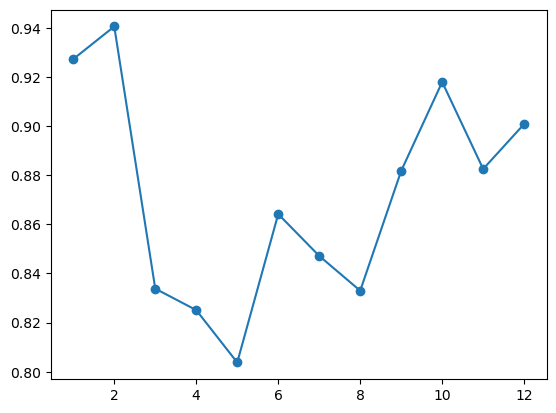

In [160]:
# Step 5: Find optimal holding period
mean_growths = first_day_df[growth_cols].mean()
print("\nMean future growths by month:\n", mean_growths)

plt.plot(np.linspace(1,12,12), mean_growths, marker='o')

In [161]:
optimal_month = mean_growths.idxmax()
optimal_value = mean_growths.max()
print(f"\nOptimal holding period: {optimal_month}")
print(f"Max average return: {optimal_value:.2%}")


Optimal holding period: future_growth_2m
Max average return: 94.05%


In [162]:
# Check uplift compared to others
uplifts = optimal_value - mean_growths.drop(optimal_month)
uplift_check = (uplifts > 0.01).all()
return_check = optimal_value < 1.0

# Output results
print(f"Uplift >1% over all others: {uplift_check}")
print(f"Average return < 1.0: {return_check}")

Uplift >1% over all others: True
Average return < 1.0: True


### Question 4: [Strategy] Simple RSI-Based Trading Strategy


**What is the total profit (in $thousands) you would have earned by investing $1000 every time a stock was oversold (RSI < 25)?**


---

#### Goal:
Apply a simple rule-based trading strategy using the **Relative Strength Index (RSI)** technical indicator to identify oversold signals and calculate profits.

---


#### Steps:

1. **Run the full notebook from Lecture 2 (33 stocks)**  
   - Ensure you can generate the merged DataFrame containing:  
     - OHLCV data  
     - Technical indicators  
     - Macro indicators  
   - Focus on getting **RSI** computed using **Code Snippets 8 and 9**.  
   - This process is essential and will help during the capstone project.

2. ⚠️ **IMPORTANT** Please use this file to solve the Home Assignment (**all next steps**)
 
   Download precomputed data using this snippet:

   ```python
   import gdown
   import pandas as pd

   file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
   gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
   df = pd.read_parquet("data.parquet", engine="pyarrow")   

In [166]:
!pip install gdown pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.9/30.9 MB 7.2 MB/s eta 0:00:00a 0:00:01


In [167]:
import gdown
import pandas as pd

file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
df = pd.read_parquet("data.parquet", engine="pyarrow")

Downloading...
From (original): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-
From (redirected): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-&confirm=t&uuid=7bdedfbb-20ee-4091-a153-a1048999068a
To: /Users/abhirupghosh/Documents/Work/job_preparation/preparation/ds_courses/stock-markets-analytics-zoomcamp/cohorts/2025/data.parquet
100%|██████████| 130M/130M [00:10<00:00, 13.0MB/s] 


3. **RSI Strategy Setup:**  
   - RSI is already available in the dataset as a field.  
   - The threshold for **oversold** is defined as `RSI < 25`.

In [172]:
# Step 3: RSI Strategy Setup
# Define RSI threshold for "oversold"
rsi_threshold = 25

4. **Filter the dataset by RSI and date:**  
   ```python
   rsi_threshold = 25
   selected_df = df[
       (df['rsi'] < rsi_threshold) &
       (df['Date'] >= '2000-01-01') &
       (df['Date'] <= '2025-06-01')
   ]

In [173]:
# Step 4: Filter by RSI and date range
selected_df = df[
    (df['rsi'] < rsi_threshold) &
    (df['Date'] >= '2000-01-01') &
    (df['Date'] <= '2025-06-01')
]

5. **Calculate Net Profit Over 25 Years:**  
   - Total number of trades: **1568**  
   - For each trade, you invest **$1000**  
   - Use the 30-day forward return (`growth_future_30d`) to compute net earnings:  
     ```python
     net_income = 1000 * (selected_df['growth_future_30d'] - 1).sum()
     ```
   - **Final Answer:**  
     What is the **net income in $K** (i.e., in thousands of dollars) that could be earned using this RSI-based oversold strategy from 2000–2025?


In [175]:
# Each trade invests $1000, and uses 30-day forward return
net_income = 1000 * (selected_df['growth_future_30d'] - 1).sum()

In [177]:
# Convert to thousands of dollars
net_income_k = net_income / 1000

# Print result
print(f"Net income over 25 years using RSI<25 strategy: ${net_income_k:.2f}K")


Net income over 25 years using RSI<25 strategy: $24.30K
